# Linear model (failed)

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


#### Импорт необходимых библиотек

In [1]:
!pip install tensorflow-addons
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
% cd drive / MyDrive / YaMlProject / models / models

/content/drive/MyDrive/YaMlProject/models/models


In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import tensorflow as tf
import tensorflow_addons as tfa
import torchvision as tv
from PIL import Image
from livelossplot import PlotLossesKeras
from sklearn.metrics import confusion_matrix

sys.path.append('../../')

from core.datasets import get_ds
from core.make_answer import make_ans_file

C:\Users\Mihail\PycharmProjects\YaMlProject\venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#### Формируем аугментацию.

##### Вариант 1.

- Пишите аугментацию. Объект класса tv.transforms.Compose или tv.transforms.{аугментация}

In [2]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-12, 12), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

#### Создаем датасеты
```python
get_ds(
    file_train, `Путь к трейновому датасету`
    file_test, `Путь к тестовому датасету`
    transform=None,  `Аугументация`
    batch_size=512,  `Размер батча`
    one_hot=False,  `Формат ответов one_hot_encoding или нет`
    val_size=0.03,  `Размер валидационного датасета, относительно data_train`
    back=1,  `На сколько уровней в директории надо подняться наверх, чтобы дойти до корневой`
)
```

Позже мы будем делать ансамбли и похожие эвристики, поэтому всегда делайте `one_hot=True`

In [3]:
train_ds, val_ds, test_ds = get_ds('smote_data_train_7000', 'repaired_data_test', transform=transformer,
                                   one_hot=True, back=2, batch_size=100)

Для дальнейшей проверки метрик разделяем валидационный датасет на x и y

In [4]:
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])

Смотрим на получившуюся агументацию.

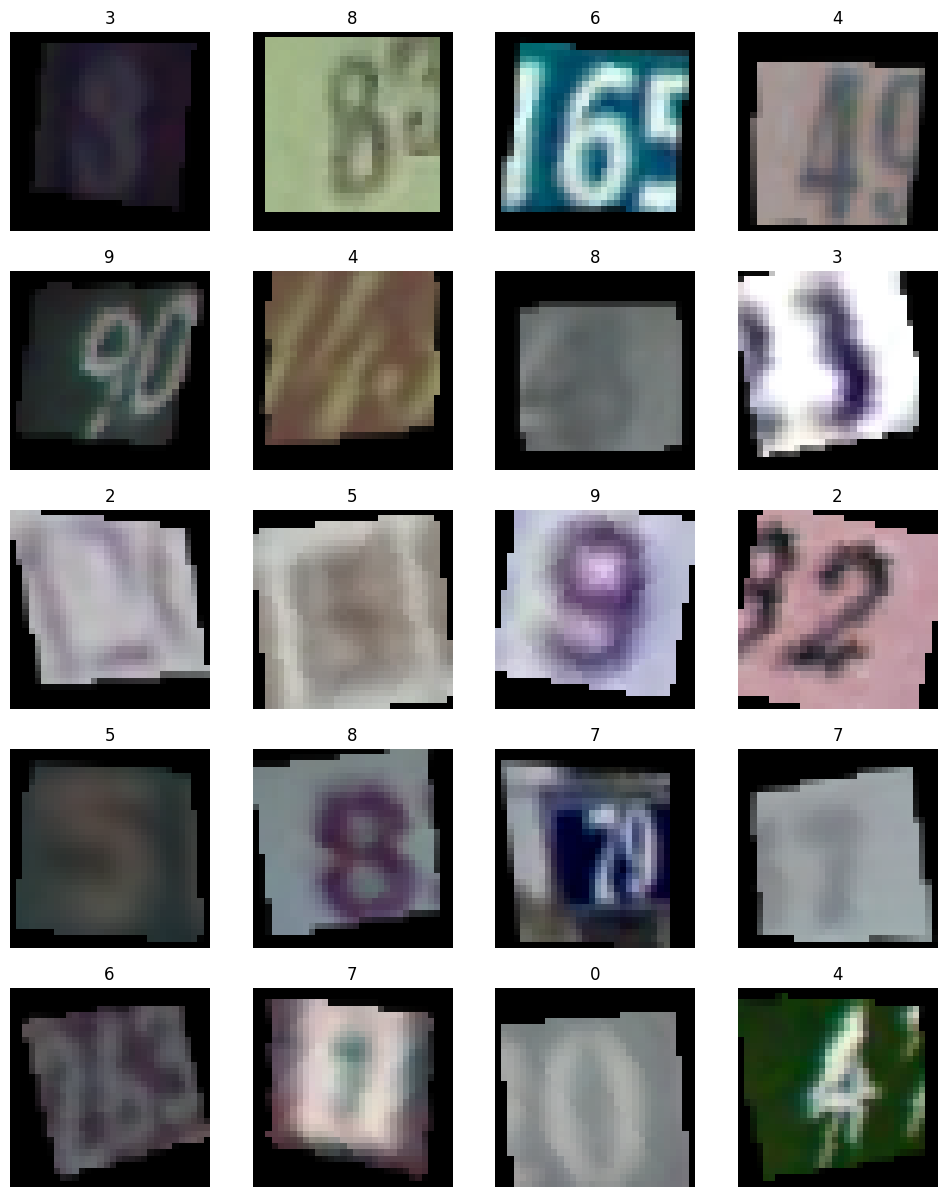

In [9]:
plt.figure(figsize=(12, 15))
train_ds_visualization = train_ds[0]
for i in range(20):
    plt.subplot(5, 4, i + 1)
    img = np.array(Image.fromarray((train_ds_visualization[0][i] * 255).astype(np.uint8), 'RGB'))
    plt.imshow(img / 255, cmap=plt.cm.binary)
    plt.title(np.argmax(train_ds_visualization[1][i]))
    plt.axis('off')
plt.show()

In [10]:
train_ds_visualization[1]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

#### Пишем модель

Про свертки и пуллинги написано у Гриши, про skip-connection написано у Миши

Для правильного использования ансамблирования, в финальном слое не пишем функцию активации. Подробнее написано у Дениса.

In [10]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(32, 32, 3), batch_size=100),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAvgPool2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10)
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (100, 30, 30, 32)         896       
                                                                 
 conv2d_25 (Conv2D)          (100, 28, 28, 32)         9248      
                                                                 
 dropout_20 (Dropout)        (100, 28, 28, 32)         0         
                                                                 
 conv2d_26 (Conv2D)          (100, 26, 26, 64)         18496     
                                                                 
 conv2d_27 (Conv2D)          (100, 24, 24, 128)        73856     
                                                                 
 dropout_21 (Dropout)        (100, 24, 24, 128)        0         
                                                                 
 batch_normalization_10 (Bat  (100, 24, 24, 128)      

In [12]:
num_model = '_s_10'

#### Создаем чекпоинты (всем уже рассказал)
- Если лень, то просто копипаст того, что я написал ниже. НЕ ЗАБЫВАЕМ МЕНЯТЬ ПЕРЕМЕННУЮ `num_model`!!!

In [13]:
metrics = ['categorical_accuracy',
           tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')]
callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    ),

    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    )
]

#### Компиляция модели
- Если будете что то менять, то только оптимизатор. Про оптимизаторы написано у Лизы.

In [14]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam(0.0016, decay=5e-5)),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


#### Обучаем модель

In [1]:
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=100, callbacks=callbacks, verbose=1)

NameError: name 'model' is not defined

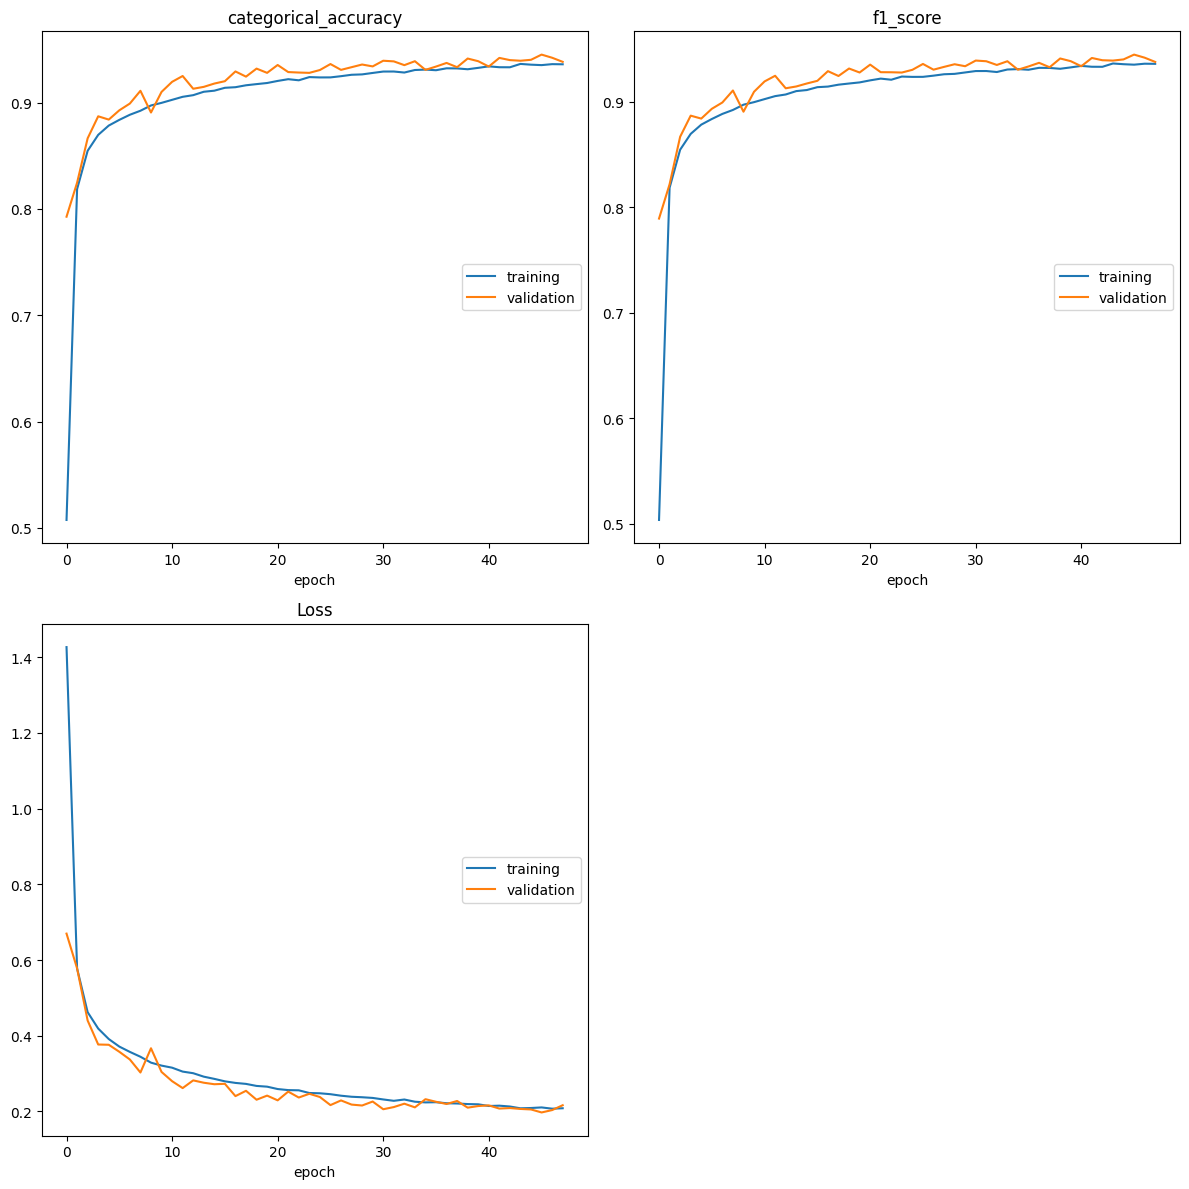

Подгружаем все чекпоинты

In [4]:
model_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_categorical_accuracy.h5')
model_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_f1_score.h5')
model_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_loss.h5')
model_avg_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5')
model_avg_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_f1_score.h5')
model_avg_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_loss.h5')

У нас поличилось три чекпоинта (три модели). Ниже указан код для получения ответов для всех чекпоинтов по валидационному датасету.

In [5]:
ans_val_categorical_accuracy = make_ans_file(model_categorical_acc, val_ds_x)
ans_val_f1_score = make_ans_file(model_f1_score, val_ds_x)
ans_val_loss = make_ans_file(model_loss, val_ds_x)
ans_val_avg_categorical_accuracy = make_ans_file(model_avg_categorical_acc, val_ds_x)
ans_val_avg_f1_score = make_ans_file(model_avg_f1_score, val_ds_x)
ans_val_avg_loss = make_ans_file(model_avg_loss, val_ds_x)
anss = [ans_val_categorical_accuracy, ans_val_f1_score, ans_val_loss, ans_val_avg_categorical_accuracy,
        ans_val_avg_f1_score, ans_val_avg_loss]

NameError: name 'val_ds_x' is not defined

Формируем валидационные ответы.

In [19]:
val_ds_y = np.argmax(val_ds_y, axis=1)

Сравниваем валидационные предикты каждого чекпоинта

In [20]:
for i in range(len(anss) - 1):
    for j in range(i + 1, len(anss)):
        if np.all(anss[i] == anss[j]):
            print(f'чекпоинты {i + 1} и {j + 1} одинаковые')

чекпоинты 1 и 2 одинаковые
чекпоинты 1 и 3 одинаковые
чекпоинты 2 и 3 одинаковые
чекпоинты 4 и 5 одинаковые
чекпоинты 4 и 6 одинаковые
чекпоинты 5 и 6 одинаковые


`Все ответы разные, значит чекпоинты сохранили модель на разных эпохах. Если ответы будут одинковые, то вывод о чекпоинте делать не надо.`

- Денис пишет ансамблинг моделей. Когда он допишет, мы применим это для формирования ответа по трем получившимся моделям. То есть, если все чекпоинты разные, то мы будем делать средний ответ по трем предиктам.

В конце смотрим на метрики и делаем выводы о том, чем хороша эта модель. Какие классы она угадывает лучше/худше всего. Дописываем какую метрику показал kaggle.

In [21]:
class MulticlassClassificationMetrics:
    def __init__(self, y_true, y_pred):
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.matrix_error = self.get_matrix_error()

    def get_matrix_error(self):
        self.class_types = np.unique([self.y_true, self.y_pred])
        TP, FN, FP, TN = [], [], [], []
        for class_type in self.class_types:
            TP.append(np.sum(np.logical_and(self.y_true == self.y_pred, self.y_true == class_type)))
            FN.append(np.sum(np.logical_and(self.y_true == class_type, self.y_pred != class_type)))
            FP.append(np.sum(np.logical_and(self.y_pred == class_type, self.y_true != class_type)))
            TN.append(np.sum(np.logical_and(self.y_pred != class_type, self.y_true != class_type)))
        return pd.DataFrame({
            'class_type': self.class_types,
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        }).set_index('class_type')

    def accuracy(self):
        return np.sum(self.y_true == self.y_pred) / self.y_true.shape[0]

    def precision(self, averaging='macro'):
        if averaging == 'macro':
            precisions = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FP'])
            return np.mean(precisions.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FP'])

    def recall(self, averaging='macro'):
        if averaging == 'macro':
            recalls = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FN'])
            return np.mean(recalls.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FN'])

    def f1_score(self, averaging='macro'):
        if averaging == 'macro':
            reverse_r = (self.matrix_error['TP'] + self.matrix_error['FN']) / self.matrix_error['TP']
            reverse_p = (self.matrix_error['TP'] + self.matrix_error['FP']) / self.matrix_error['TP']
            f1_scores = 2 / (reverse_r + reverse_p)
            return np.mean(f1_scores.replace(np.nan, 0))
        elif averaging == 'micro':
            p = self.precision(averaging)
            r = self.recall(averaging)
            return 2 * p * r / (p + r)

    def metrics(self, averaging='macro'):
        return {
            'accuracy': self.accuracy(),
            'precision': self.precision(averaging),
            'recall': self.recall(averaging),
            'f1_score': self.f1_score(averaging),
        }

    def __str__(self):
        headers = {
            'selector': '*',
            'props': 'background-color: darkgreen; color: white; font-size: 12pt;',
        }
        che_super_mega_puper_visualization_of_cell = {
            'selector': 'td:hover',
            'props': 'background-color: green; color: white;',
        }
        display(
            self.matrix_error
            .style
            .set_table_styles([
                headers,
                che_super_mega_puper_visualization_of_cell,
            ])
            .set_properties(**{'background-color': 'lightgreen',
                               'color': 'black', 'font-size': '12pt'})
        )
        return ''

    def __repr__(self):
        return (
            f'MulticlassClassificationMetrics(class_types={self.class_types})'
            .replace("'", '').replace(',', ';'))

### Accuracy чекпоинт

In [23]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,495,4390,12,4
1,471,4396,25,9
2,499,4381,16,5
3,495,4379,17,10
4,505,4381,10,5
5,472,4405,10,14
6,474,4401,9,17
7,469,4406,5,21
8,442,4439,5,15


{'accuracy': 0.9773515609059376,
 'precision': 0.9776869620225307,
 'recall': 0.977163321960053,
 'f1_score': 0.9773187191403638}

### Loss чекпоинт

In [24]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,495,4390,12,4
1,471,4396,25,9
2,499,4381,16,5
3,495,4379,17,10
4,505,4381,10,5
5,472,4405,10,14
6,474,4401,9,17
7,469,4406,5,21
8,442,4439,5,15


{'accuracy': 0.9773515609059376,
 'precision': 0.9776869620225307,
 'recall': 0.977163321960053,
 'f1_score': 0.9773187191403638}

### F1-score чекпоинт

In [25]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_f1_score)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,495,4390,12,4
1,471,4396,25,9
2,499,4381,16,5
3,495,4379,17,10
4,505,4381,10,5
5,472,4405,10,14
6,474,4401,9,17
7,469,4406,5,21
8,442,4439,5,15


{'accuracy': 0.9773515609059376,
 'precision': 0.9776869620225307,
 'recall': 0.977163321960053,
 'f1_score': 0.9773187191403638}

### Среднее скользящее по accuracy чекпоинт

In [26]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,494,4398,4,5
1,470,4409,12,10
2,499,4390,7,5
3,493,4388,8,12
4,507,4386,5,3
5,478,4404,11,8
6,483,4399,11,8
7,482,4405,6,8
8,444,4438,6,13


{'accuracy': 0.98469700061212,
 'precision': 0.9846718405259809,
 'recall': 0.984579110998921,
 'f1_score': 0.9846141241249693}

### Скользящее среднее по F1-score чекпоинт

In [27]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_f1_score)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,494,4398,4,5
1,470,4409,12,10
2,499,4390,7,5
3,493,4388,8,12
4,507,4386,5,3
5,478,4404,11,8
6,483,4399,11,8
7,482,4405,6,8
8,444,4438,6,13


{'accuracy': 0.98469700061212,
 'precision': 0.9846718405259809,
 'recall': 0.984579110998921,
 'f1_score': 0.9846141241249693}

### Скользящее среднее по Loss чекпоинт

In [28]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,494,4398,4,5
1,470,4409,12,10
2,499,4390,7,5
3,493,4388,8,12
4,507,4386,5,3
5,478,4404,11,8
6,483,4399,11,8
7,482,4405,6,8
8,444,4438,6,13


{'accuracy': 0.98469700061212,
 'precision': 0.9846718405259809,
 'recall': 0.984579110998921,
 'f1_score': 0.9846141241249693}

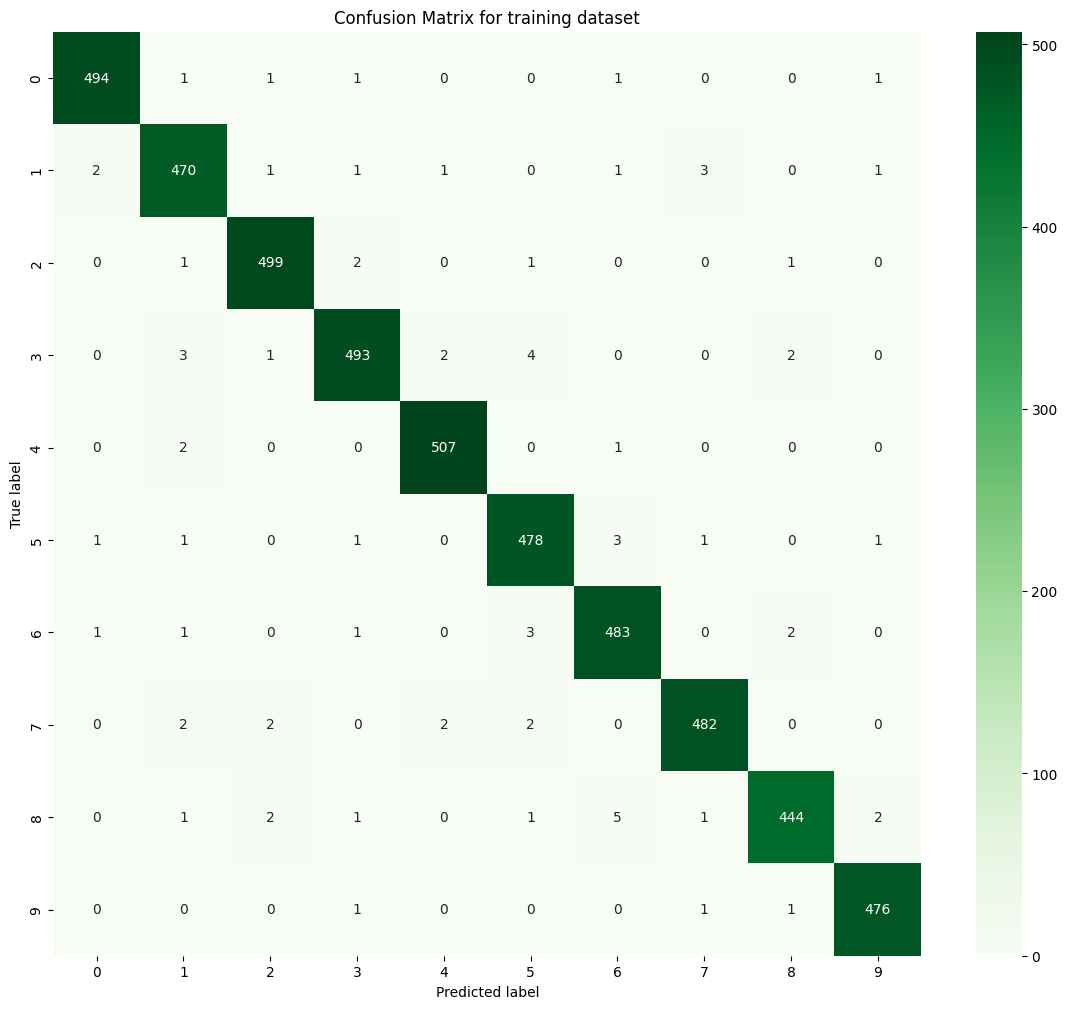

In [29]:
matrix = confusion_matrix(val_ds_y, ans_val_avg_categorical_accuracy)

fig, ax = plt.subplots(figsize=(14, 12))
seaborn.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

- Сохраняем ответы.

In [10]:
ans_test_categorical_accuracy = make_ans_file(model_categorical_acc, test_ds,
                                              f'../answers/model{num_model}_categorical_accuracy.csv')
ans_test_avg_categorical_accuracy = make_ans_file(model_avg_categorical_acc, test_ds,
                                                  f'../answers/model{num_model}_avg_categorical_accuracy.csv')

782/782 [==============================] - 428s 544ms/step


Проверяем ответы (одинаковые они или нет), чтоб не терять кол-во отправок ответов на kaggle в день.

In [32]:
for i in range(len(anss) - 1):
    for j in range(i + 1, len(anss)):
        if np.all(anss[i] == anss[j]):
            print(f'чекпоинты {i + 1} и {j + 1} одинаковые')

чекпоинты 1 и 2 одинаковые
чекпоинты 1 и 3 одинаковые
чекпоинты 2 и 3 одинаковые
чекпоинты 4 и 5 одинаковые
чекпоинты 4 и 6 одинаковые
чекпоинты 5 и 6 одинаковые


- Accuracy чекпоинт: 0.93493
- Loss чекпоинт: 0.92866